In [1]:
%qtconsole

/Users/kungfujam/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


# Single Layer Models

***
### Note on storing matrices in computer memory

Suppose you want to store the following matrix in memory: $\left[ \begin{array}{ccc}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \end{array} \right]$ 

If you allocate the memory at once for the whole matrix, then the above matrix would be organised as a vector in one of two possible forms:

* Row-wise layout where the order would look like: $\left [ \begin{array}{ccccccccc}
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \end{array} \right ]$
* Column-wise layout where the order would look like: $\left [ \begin{array}{ccccccccc}
1 & 4 & 7 & 2 & 5 & 8 & 3 & 6 & 9 \end{array} \right ]$

Although `numpy` can easily handle both formats (possibly with some computational overhead), in our code we will stick with the more modern (and default) `C`-like approach and use the row-wise format (in contrast to Fortran that used a column-wise approach). 

This means, that in this tutorial:
* vectors are kept row-wise $\mathbf{x} = (x_1, x_1, \ldots, x_D) $ (rather than $\mathbf{x} = (x_1, x_1, \ldots, x_D)^T$)
* similarly, in case of matrices we will stick to: $\left[ \begin{array}{cccc}
x_{11} & x_{12} & \ldots & x_{1D} \\
x_{21} & x_{22} & \ldots & x_{2D} \\
x_{31} & x_{32} & \ldots & x_{3D} \\ \end{array} \right]$ and each row (i.e. $\left[ \begin{array}{cccc} x_{11} & x_{12} & \ldots & x_{1D} \end{array} \right]$) represents a single data-point (like one MNIST image or one window of observations)

In lecture slides you will find the equations following the conventional mathematical approach, using column vectors, but you can easily map between column-major and row-major organisations using a matrix transpose.

***

## Linear and Affine Transforms

The basis of all linear models is the so called affine transform, which is a transform that implements a linear transformation and translation of the input features. The transforms we are going to use are parameterised by:

  * A weight matrix $\mathbf{W} \in \mathbb{R}^{D\times K}$: where element $w_{ik}$ is the weight from input $x_i$ to output $y_k$
  * A bias vector $\mathbf{b}\in R^{K}$ : where element $b_{k}$ is the bias for output $k$

Note, the bias is simply some additive term, and can be easily incorporated into an additional row in weight matrix and an additional input in the inputs which is set to $1.0$ (as in the below picture taken from the lecture slides). However, here (and in the code) we will keep them separate.

![Making Predictions](res/singleLayerNetWts-1.png)

For instance, for the above example of 5-dimensional input vector by $\mathbf{x} = (x_1, x_2, x_3, x_4, x_5)$, weight matrix $\mathbf{W}=\left[ \begin{array}{ccc}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23} \\
w_{31} & w_{32} & w_{33} \\
w_{41} & w_{42} & w_{43} \\
w_{51} & w_{52} & w_{53} \\ \end{array} \right]$, bias vector $\mathbf{b} = (b_1, b_2, b_3)$ and outputs $\mathbf{y} = (y_1, y_2, y_3)$, one can write the transformation as follows:

(for the $i$-th output)

(1) $
\begin{equation}
   y_i = b_i + \sum_j x_jw_{ji}
\end{equation}
$

or the equivalent vector form (where $\mathbf w_i$ is the $i$-th column of $\mathbf W$, but note, when we **slice** the $i$th column we will get a **vector** $\mathbf w_i = (w_{1i}, w_{2i},  w_{3i},  w_{4i}, w_{5i})$, hence the transpose for $\mathbf w_i$ in the below equation):

(2) $
\begin{equation}
   y_i = b_i + \mathbf x \mathbf w_i^T
\end{equation}
$

The same operation can be also written in matrix form, to compute all the outputs $\mathbf{y}$ at the same time:

(3) $
\begin{equation}
  \mathbf y=\mathbf x\mathbf W + \mathbf b
\end{equation}
$

This is equivalent to slides 12/13 in lecture 1, except we are using row vectors.

When $\mathbf{x}$ is a mini-batch (contains $B$ data-points of dimension $D$ each), i.e. $\left[ \begin{array}{cccc}
x_{11} & x_{12} & \ldots & x_{1D} \\
x_{21} & x_{22} & \ldots & x_{2D} \\
\cdots \\
x_{B1} & x_{B2} & \ldots & x_{BD} \\ \end{array} \right]$ equation (3) effectively becomes to be

(4) $
\begin{equation}
  \mathbf Y=\mathbf X\mathbf W + \mathbf b
\end{equation}
$

where $\mathbf{W} \in \mathbb{R}^{D\times K}$ and both $\mathbf{X}\in\mathbb{R}^{B\times D}$ and $\mathbf{Y}\in\mathbb{R}^{B\times K}$ are matrices, and $\mathbf{b}\in\mathbb{R}^{1\times K}$ needs to be <a href="http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html">broadcasted</a> $B$ times (numpy will do this by default). However, we will not make an explicit distinction between a special case for $B=1$ and $B>1$ and simply use equation (3) instead, although $\mathbf{x}$ and hence $\mathbf{y}$ could be matrices. From an implementation point of view, it does not matter.

The desired functionality for matrix multiplication in numpy is provided by <a href="http://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html">numpy.dot</a> function. If you haven't use it so far, get familiar with it as we will use it extensively.

### A general note on random number generators

It is generally a good practice (for machine learning applications **not** for cryptography!) to seed a pseudo-random number generator once at the beginning of the experiment, and use it later through the code where necesarry. This makes it easier to reproduce results since random initialisations can be replicated. As such, within this course we are going use a single random generator object, similar to the below:

In [9]:
import numpy as np

#initialise the random generator to be used later
seed=[2015, 10, 1]
random_generator = np.random.RandomState(seed)

## Exercise 1 

Using `numpy.dot`, implement **forward** propagation through the linear transform defined by equations (3) and (4) for $B=1$ and $B>1$ i.e. use parameters $\mathbf{W}$ and $\mathbf{b}$ with data $\mathbf{X}$ to determine $\mathbf{Y}$. Use `MNISTDataProvider` (introduced last week) to generate $\mathbf{X}$. We are going to write a function for each equation:
1. `y1_equation_1`: Return the value of the $1^{st}$ dimension of $\mathbf{y}$ (the output of the first output node) given a single training data point $\mathbf{x}$ using a sum
1. `y1_equation_2`: Repeat above using vector multiplication (use `numpy.dot()`)
1. `y_equation_3`: Return the value of $\mathbf{y}$ (the whole output layer) given a single training data point $\mathbf{x}$
1. `Y_equation_4`: Return the value of $\mathbf{Y}$ given $\mathbf{X}$

We have initialised $\mathbf{b}$ to zeros and randomly generated $\mathbf{W}$ for you. The constants introduced above are:
* The number of data points $B = 3$
* The dimensionality of the input $D = 784$
* The dimensionality of the output $K = 10$

In [10]:
from mlp.dataset import MNISTDataProvider

mnist_dp = MNISTDataProvider(dset='valid', batch_size=3, max_num_batches=1, randomize=False)
B = 3
D = 784
K = 10
irange = 0.1
W = random_generator.uniform(-irange, irange, (D, K)) 
b = np.zeros((10,))


In [13]:

mnist_dp.reset()

#implement following functions, then run the cell
def y1_equation_1(x, W, b):
    k = 0
    s = 0
    for j in xrange(len(x)):
        s += x[j] * W[j,k]
    return b[k] + s
    
def y1_equation_2(x, W, b):
    k = 0
    return np.dot(x, W[:,k]) + b[k]

def y_equation_3(x, W, b):
    k=0
    return np.dot(x[k], W) + b

def Y_equation_4(X, W, b):
    #use numpy.dot
    return np.dot(X, W) + b

for X, t in mnist_dp:
    n = 0
    y1e1 = y1_equation_1(X[n], W, b)
    y1e2 = y1_equation_2(X[n], W, b)
    ye3 = y_equation_3(X[n], W, b)
    Ye4 = Y_equation_4(X, W, b)

print 'y1e1', y1e1
print 'y1e2', y1e2
print 'ye3', ye3
print 'Ye4', Ye4
    

y1e1 0.55861474982
y1e2 0.55861474982
ye3 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Ye4 [[ 0.55861475  0.79450077  0.17439693  0.00265688  0.66272539 -0.09985686
   0.56468591  0.58105588 -0.18613727  0.08151257]
 [-0.43965864  0.59573972 -0.22691119  0.26767124 -0.31343979  0.07224664
  -0.19616183  0.0851733  -0.24088286 -0.19305162]
 [-0.20176359  0.42394166 -1.03984446  0.15492101  0.15694745 -0.53741022
   0.05887668 -0.21124527 -0.07870156 -0.00506471]]


## Exercise 2

Modify the examples from Exercise 1 to perform **backward** propagation, that is, given $\mathbf{y}$ (obtained in the previous step) and weight matrix $\mathbf{W}$, project $\mathbf{y}$ onto the input space $\mathbf{x}$ (ignore or set to zero the biases towards $\mathbf{x}$ in backward pass, and note, we are **not** trying to reconstruct the original $\mathbf{x}$). Mathematically, we are interested in the following transformation: $\mathbf{z}=\mathbf{y}\mathbf{W}^T$

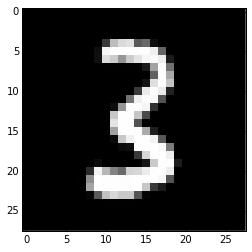

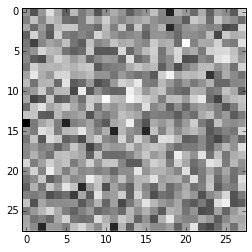

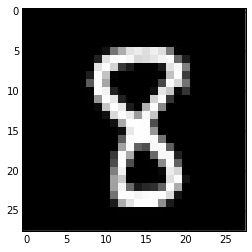

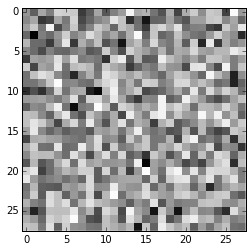

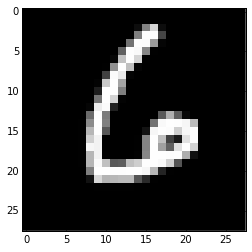

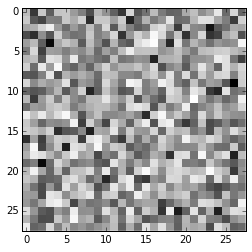

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

def show_mnist_image(img):
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(img, cmap=cm.Greys_r, interpolation="None")
    plt.show()
    
def backprop(Y, W):
    return np.dot(Y, W.T)

mnist_dp.reset()
for X, t in mnist_dp:
    X1 = np.copy(X)
    Y = Y_equation_4(X, W, b)
    X2 = backprop(Y, W)

for i in range(X1.shape[0]):
    show_mnist_image(X1[i].reshape(28, 28))
    show_mnist_image(X2[i].reshape(28, 28))

***
## Exercise 3 (optional)

In case you do not fully understand how matrix-vector and/or matrix-matrix products work, consider implementing `my_dot_mat_mat` function  (you have been given `my_dot_vec_mat` code to look at as an example) which takes as the input the following arguments:

* D-dimensional input vector $\mathbf{x} = (x_1, x_2, \ldots, x_D) $.
* Weight matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$:

and returns:

* K-dimensional output vector $\mathbf{y} = (y_1, \ldots, y_K) $

Your job is to write a variant that works in a mini-batch mode where both $\mathbf{x}\in\mathbb{R}^{B\times D}$ and $\mathbf{y}\in\mathbb{R}^{B\times K}$ are matrices in which each rows contain one of $B$ data-points from mini-batch (rather than  $\mathbf{x}\in\mathbb{R}^{D}$ and $\mathbf{y}\in\mathbb{R}^{K}$).

In [16]:
def my_dot_vec_mat(x, W):
    J = x.shape[0]
    K = W.shape[1]
    assert (J == W.shape[0]), (
        "Number of columns of x expected to "
        " to be equal to the number of rows in "
        "W, bot got shapes %s, %s" % (x.shape, W.shape)
    )
    y = np.zeros((K,))
    for k in xrange(0, K):
        for j in xrange(0, J):
            y[k] += x[j] * W[j,k]
                
    return y

In [17]:
irange = 0.1 #+-range from which we draw the random numbers

x = random_generator.uniform(-irange, irange, (5,)) 
W = random_generator.uniform(-irange, irange, (5,3)) 

y_my = my_dot_vec_mat(x, W)
y_np = np.dot(x, W)

same = np.allclose(y_my, y_np)

if same:
    print 'Well done!'
else:
    print 'Matrices are different:'
    print 'y_my is: ', y_my
    print 'y_np is: ', y_np

Well done!


In [18]:
def my_dot_mat_mat(x, W):
    I = x.shape[0]
    J = x.shape[1]
    K = W.shape[1]
    assert (J == W.shape[0]), (
        "Number of columns in of x expected to "
        " to be the same as rows in W, got"
    )
    #allocate the output container
    y = np.zeros((I, K))
    
    #implement here matrix-matrix inner product here
    for k in xrange(0, K):
        for j in xrange(0, J):
            for i in xrange(0, I):
                y[i,k] += x[i,j] * W[j,k]
                
    return y

Test whether you get comparable numbers to what numpy is producing:

In [19]:
irange = 0.1 #+-range from which we draw the random numbers

x = random_generator.uniform(-irange, irange, (2,5)) 
W = random_generator.uniform(-irange, irange, (5,3)) 

y_my = my_dot_mat_mat(x, W)
y_np = np.dot(x, W)

same = np.allclose(y_my, y_np)

if same:
    print 'Well done!'
else:
    print 'Matrices are different:'
    print 'y_my is: ', y_my
    print 'y_np is: ', y_np

Well done!


Now we benchmark each approach (we do it in separate cells, as timeit currently can measure whole cell execuiton only).

In [20]:
#generate bit bigger matrices, to better evaluate timings
x = random_generator.uniform(-irange, irange, (10, 1000))
W = random_generator.uniform(-irange, irange, (1000, 100))

In [21]:
print 'my_dot timings:'
%timeit -n10 my_dot_mat_mat(x, W)

my_dot timings:
10 loops, best of 3: 755 ms per loop


In [22]:
print 'numpy.dot timings:'
%timeit -n10 np.dot(x, W)

numpy.dot timings:
10 loops, best of 3: 132 µs per loop


**Optional section ends here**
***

# Iterative learning of linear models

We will learn the model with stochastic gradient descent on N data-points using mean square error (MSE) loss function, which is defined as follows:

(5) $
E = \frac{1}{2} \sum_{n=1}^N ||\mathbf{y}^n - \mathbf{t}^n||^2 =  \sum_{n=1}^N E^n \\
  E^n = \frac{1}{2} ||\mathbf{y}^n - \mathbf{t}^n||^2
$

(6) $ E^n = \frac{1}{2} \sum_{k=1}^K (y_k^n - t_k^n)^2 $
  
Hence, the gradient w.r.t (with respect to) the $r$ output y of the model is defined as, so called delta function, $\delta_r$: 

(8) $\frac{\partial{E^n}}{\partial{y_{r}}} = (y^n_r - t^n_r) =  \delta^n_r \quad ; \quad
    \delta^n_r = y^n_r - t^n_r \\
    \frac{\partial{E}}{\partial{y_{r}}} = \sum_{n=1}^N \frac{\partial{E^n}}{\partial{y_{r}}} = \sum_{n=1}^N \delta^n_r
$

Similarly, using the above $\delta^n_r$ one can express the gradient of the  weight $w_{sr}$ (from the s-th input to the r-th output) for linear model and MSE cost as follows:

(9) $
    \frac{\partial{E^n}}{\partial{w_{sr}}} = (y^n_r - t^n_r)x_s^n =  \delta^n_r x_s^n \quad\\
    \frac{\partial{E}}{\partial{w_{sr}}} = \sum_{n=1}^N \frac{\partial{E^n}}{\partial{w_{rs}}} = \sum_{n=1}^N \delta^n_r x_s^n
$

and the gradient for bias parameter at the $r$-th output is:

(10) $
    \frac{\partial{E}}{\partial{b_{r}}} = \sum_{n=1}^N \frac{\partial{E^n}}{\partial{b_{r}}} = \sum_{n=1}^N \delta^n_r
$


![Making Predictions](res/singleLayerNetPredict.png)
 
  * Input vector $\mathbf{x} = (x_1, x_2, \ldots, x_D) $
  * Output scalar $y_1$
  * Weight matrix $\mathbf{W}$: $w_{ik}$ is the weight from input $x_i$ to output $y_k$. Note, here this is really a vector since a single scalar output, y_1.
  * Scalar bias $b$ for the only output in our model 
  * Scalar target $t$ for the only output in out model
  
First, ensure you can make use of the data provider (note, for training data has been normalised to zero mean and unit variance, hence different effective range than one can find in file):

In [26]:
from mlp.dataset import MetOfficeDataProvider

modp = MetOfficeDataProvider(10, batch_size=10, max_num_batches=2, randomize=False)

%precision 2
for x, t in modp:
    print 'X shape: %r\nBatch 1 X:\n%r' % (x.shape, x)
    print 'T shape: %r\nBatch 1 T:\n%r' % (t.shape, t)
    break

X shape: (10, 10)
Batch 1 X:
array([[-0.08, -0.06, -0.04, -0.13, -0.13, -0.13, -0.1 ,  0.08, -0.06,
         0.04],
       [-0.06, -0.04, -0.13, -0.13, -0.13, -0.1 ,  0.08, -0.06,  0.04,
         0.12],
       [-0.04, -0.13, -0.13, -0.13, -0.1 ,  0.08, -0.06,  0.04,  0.12, -0.1 ],
       [-0.13, -0.13, -0.13, -0.1 ,  0.08, -0.06,  0.04,  0.12, -0.1 ,
        -0.12],
       [-0.13, -0.13, -0.1 ,  0.08, -0.06,  0.04,  0.12, -0.1 , -0.12,
        -0.03],
       [-0.13, -0.1 ,  0.08, -0.06,  0.04,  0.12, -0.1 , -0.12, -0.03,
         0.12],
       [-0.1 ,  0.08, -0.06,  0.04,  0.12, -0.1 , -0.12, -0.03,  0.12,  0.5 ],
       [ 0.08, -0.06,  0.04,  0.12, -0.1 , -0.12, -0.03,  0.12,  0.5 ,
        -0.08],
       [-0.06,  0.04,  0.12, -0.1 , -0.12, -0.03,  0.12,  0.5 , -0.08,
         0.22],
       [ 0.04,  0.12, -0.1 , -0.12, -0.03,  0.12,  0.5 , -0.08,  0.22,
        -0.03]])
T shape: (10, 1)
Batch 1 T:
array([[ 0.12],
       [-0.1 ],
       [-0.12],
       [-0.03],
       [ 0.12],
       [

## Exercise 4

The below code implements a very simple variant of stochastic gradient descent for the rainfall prediction example. Your task is to implement 5 functions in the next cell and then run two next cells that 1) build sgd functions and 2) run the actual training.

In [62]:

#When implementing those, take into account the mini-batch case, for which one is
#expected to sum the errors for each example

def fprop(X, W, b):
    #code implementing eq. (3)
    # [JO] Actally it's (4)
    Y = np.dot(X, W) + b
    return Y

def cost(Y, T):
    # y and t are size N x K 
    #Sum Square Error cost, equation (5)
    assert(Y.shape == T.shape), "shape of Y and T must match [Y is %s, T is %s]" \
        % (Y.shape, T.shape)
    N = Y.shape[0]
    return np.trace((Y-T).dot((Y-T).T)) / float(N)
    # this method only works for N x 1
#     N = len(y)
#     delta = y - t
#     SSE = 0.5 * np.dot(delta, delta)  # valid as delta shape (N, )
#     MSE = SSE/N
#     return MSE

def cost_grad(Y, T):
    #Gradient of the cost w.r.t y equation (8)
    delta = Y - T
    return delta

def cost_wrt_W(cost_grad, X):
    # Gradient of the cost w.r.t W, equation (9)
    # X is N-by-D, cost_grad is N-by-K
    # return is D-by-K
    return np.dot(X.T, cost_grad)
    
def cost_wrt_b(cost_grad):
    #Gradient of the cost w.r.t to b, equation (10)
    return np.sum(cost_grad, axis = 0)

In [63]:
def sgd_epoch(data_provider, W, b, learning_rate):
    # Convention
    mse_stats = []
    #get the minibatch of data
    for X, T in data_provider:
        #1. get the estimate of y
        Y = fprop(X, W, b)

        #2. compute the loss function
        tmp = cost(Y, T)
        mse_stats.append(tmp)
        
        #3. compute the grad of the cost w.r.t the output layer activation y
        #i.e. how the cost changes when output y changes
        cost_grad_deltas = cost_grad(Y, T)

        #4. compute the gradients w.r.t model's parameters
        grad_W = cost_wrt_W(cost_grad_deltas, X)
        grad_b = cost_wrt_b(cost_grad_deltas)

        #4. Update the model, we update with the mean gradient
        # over the minibatch, rather than sum of particular gradients
        # in a minibatch, to do so we scale the learning rate by batch_size
        batch_size = X.shape[0]
        effect_learn_rate = learning_rate / batch_size

        W = W - effect_learn_rate * grad_W
        b = b - effect_learn_rate * grad_b
    
    return W, b, np.mean(mse_stats)

def sgd(data_provider, W, b, learning_rate=0.1, max_epochs=10):
    
    for epoch in xrange(0, max_epochs):
        #reset the data provider
        data_provider.reset()
        
        #train for one epoch
        W, b, mean_cost = \
            sgd_epoch(data_provider, W, b, learning_rate)
                
        print "MSE training cost after %d-th epoch is %f" % (epoch + 1, mean_cost)
    
    return W, b
        
        

Testing the Mean MSE for 100 random batches of size 10
Batch 1 MSE = 0.049
Batch 2 MSE = 0.064
Batch 3 MSE = 0.060
Batch 4 MSE = 0.036
Batch 5 MSE = 0.012
Batch 6 MSE = 0.033
Batch 7 MSE = 0.015
Batch 8 MSE = 0.026
Batch 9 MSE = 0.018
Batch 10 MSE = 0.020
...
Overall mean MSE: 0.035
Overall median MSE: 0.028
Overall variance MSE: 0.001


(array([ 23.,  30.,  15.,  12.,   8.,   2.,   6.,   3.,   0.,   1.]),
 array([ 0.  ,  0.02,  0.03,  0.04,  0.05,  0.06,  0.08,  0.09,  0.1 ,
         0.11,  0.13]),
 <a list of 10 Patch objects>)

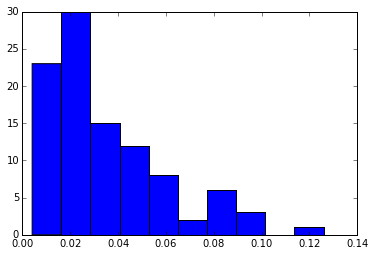

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

# Give some context as to the expected error by predicting
# target as mean rainfall over last 12 days
modp = MetOfficeDataProvider(12, batch_size=10, max_num_batches=100, randomize=True)
print "Testing the Mean MSE for 100 random batches of size 10"

mse_stats = []
for (i, (X, T)) in enumerate(modp):
    Y = np.mean(X, axis=1, keepdims=True)
    tmp = cost(Y, T)
    mse_stats.append(tmp)
    if i < 10:
        print "Batch %d MSE = %0.3f" % (i+1, tmp)
    elif i == 10:
        print "..."

print "Overall mean MSE: %0.3f" % (np.mean(mse_stats))
print "Overall median MSE: %0.3f" % (np.median(mse_stats))
print "Overall variance MSE: %0.3f" % (np.var(mse_stats))

plt.hist(mse_stats)

In [71]:

#some hyper-parameters
window_size = 12
irange = 0.1
learning_rate = 0.01
max_epochs=40

# note, while developing you can set max_num_batches to some positive number to limit
# the number of training data-points (you will get feedback faster)
# [JO] I think all that -100 does is ensure that `presented_max` in MetOfficeDataProvider is
# Always false i.e. you could use whatever negative number
mdp = MetOfficeDataProvider(window_size, batch_size=10, max_num_batches=-1, randomize=False)

#initialise the parameters
W = random_generator.uniform(-irange, irange, (window_size, 1))
b = random_generator.uniform(-irange, irange, (1, ))

#train the model
sgd(mdp, W, b, learning_rate=learning_rate, max_epochs=max_epochs)


MSE training cost after 1-th epoch is 0.031637
MSE training cost after 2-th epoch is 0.029942
MSE training cost after 3-th epoch is 0.029684
MSE training cost after 4-th epoch is 0.029623
MSE training cost after 5-th epoch is 0.029607
MSE training cost after 6-th epoch is 0.029602
MSE training cost after 7-th epoch is 0.029601
MSE training cost after 8-th epoch is 0.029600
MSE training cost after 9-th epoch is 0.029600
MSE training cost after 10-th epoch is 0.029600
MSE training cost after 11-th epoch is 0.029600
MSE training cost after 12-th epoch is 0.029600
MSE training cost after 13-th epoch is 0.029600
MSE training cost after 14-th epoch is 0.029600
MSE training cost after 15-th epoch is 0.029600
MSE training cost after 16-th epoch is 0.029600
MSE training cost after 17-th epoch is 0.029600
MSE training cost after 18-th epoch is 0.029600
MSE training cost after 19-th epoch is 0.029600
MSE training cost after 20-th epoch is 0.029600
MSE training cost after 21-th epoch is 0.029600
M

(array([[  1.66e-02],
        [ -4.17e-03],
        [  3.69e-04],
        [  7.89e-03],
        [ -1.28e-04],
        [  1.13e-02],
        [  3.73e-02],
        [  2.85e-02],
        [  3.80e-02],
        [  5.85e-02],
        [  7.10e-02],
        [  2.56e-01]]), array([ 0.01]))

## Exercise 5

Modify the above prediction (regression) problem so the model makes a binary classification whether the the weather is going to be one of those \{rainy, not-rainy} (look at slide 12 of the 2nd lecture)

Tip: You need to introduce the following changes:
1. Modify `MetOfficeDataProvider` (for example, inherit from MetOfficeDataProvider to create a new class MetOfficeDataProviderBin) and modify `next()` function so it returns as `targets` either 0 (not-rainy - if the the amount of rain [before mean/variance normalisation] is equal to 0) or 1 (rainy -- otherwise).
2. Modify the functions from previous exercise so the fprop implements `sigmoid` on top of affine transform.
3. Modify cost function to binary cross-entropy
4. Make sure you compute the gradients correctly (as you have changed both the output and the cost)


In [72]:
class MetOfficeDataProviderBin(MetOfficeDataProvider):
    pass
# Leaving this for now
